In [223]:
import os
import pandas as pd
import torch
from argparse import Namespace
from torch.utils.data import DataLoader
from MLPpatchLatent import Model

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")

from config.config_KR import *
from model.dfm_model import * 
from model.var_model import *
from model.kalman_filter import *
from utils.deep_learning import *
from utils.data_loader import *
from utils.visualization import *

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", message="A date index has been provided, but it has no associated frequency information")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [224]:
target_df = load_target_data(TARGET_PATH)
target_df_train = target_df[target_df.index < TEST_DATE]
target_df_test  = target_df[target_df.index >= TEST_DATE]

In [234]:
target_df[region_label].diff()

2006-01-15    NaN
2006-02-15   -0.8
2006-03-15   -1.6
2006-04-15    0.1
2006-05-15    0.5
             ... 
2024-07-15   -0.4
2024-08-15    0.2
2024-09-15    0.9
2024-10-15    1.5
2024-11-15   -0.9
Name: Jeju_HPI, Length: 227, dtype: float64

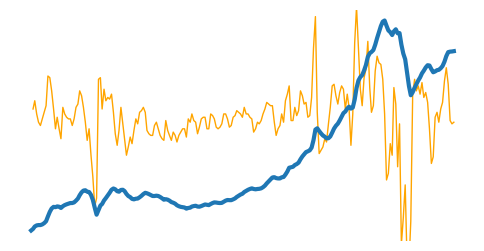

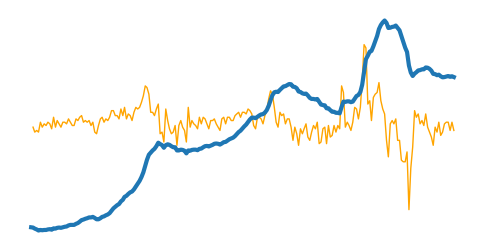

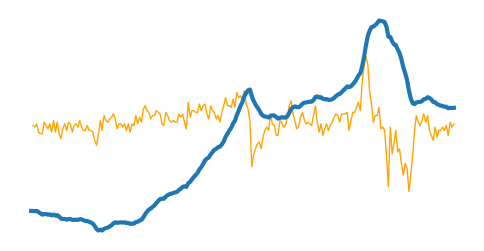

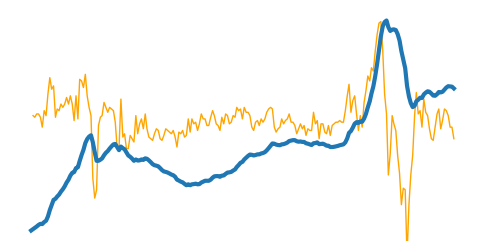

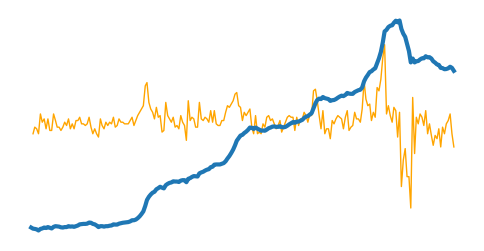

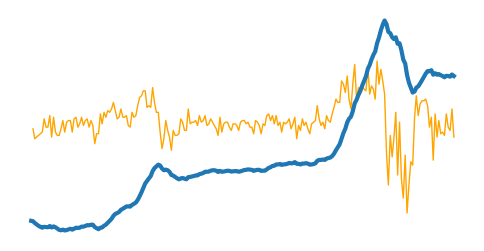

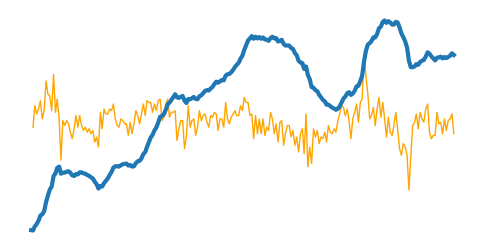

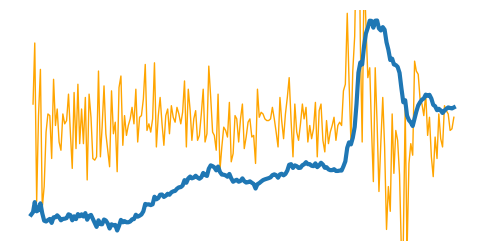

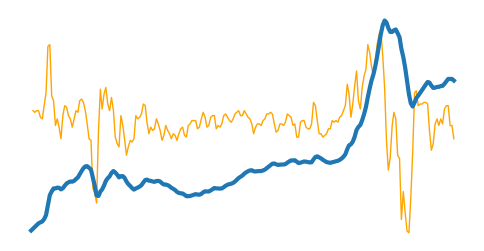

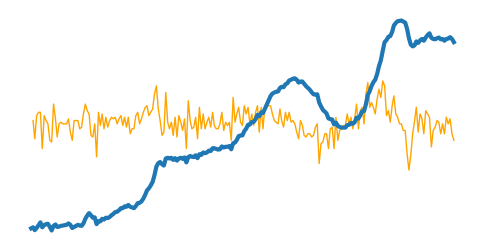

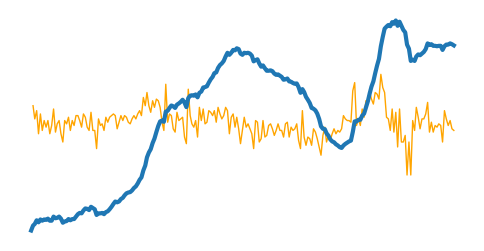

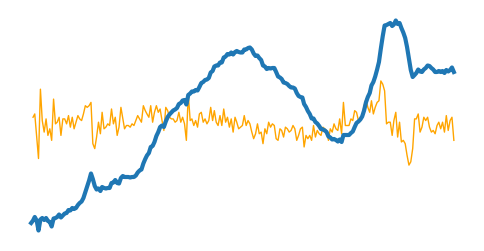

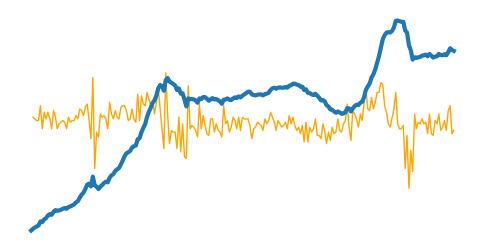

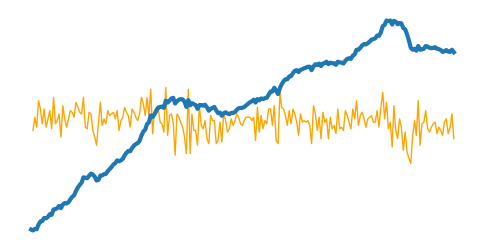

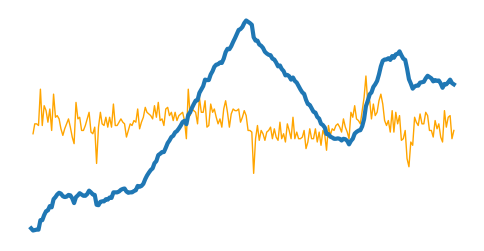

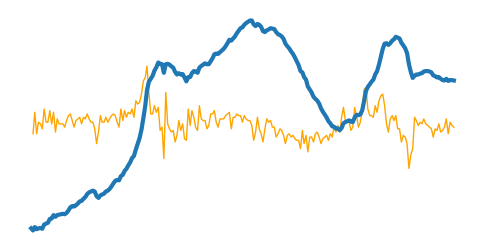

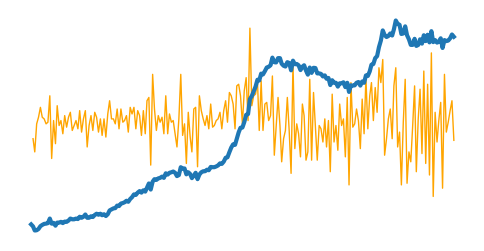

In [ ]:
for i in target_df.columns:
    fig, ax1 = plt.subplots(figsize=(6,3))
    region_label = i
    ax1.plot(target_df[region_label].diff(),linewidth=1, color="orange")
    ax1.set_ylim(-8, 8)
    ax2 = ax1.twinx()
    ax2.plot(target_df[region_label], linewidth=3)
    ax1.axis("off")
    ax2.axis("off")
    plt.show()

Seoul_HPI


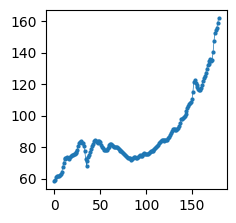

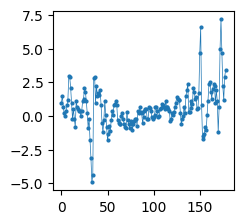

Busan_HPI


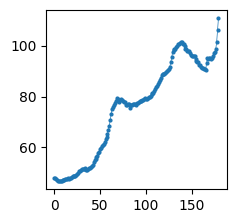

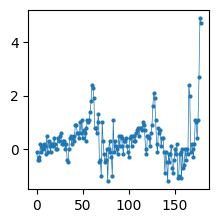

Sejong_HPI


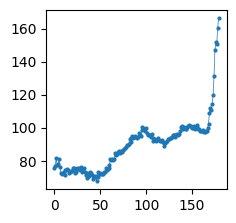

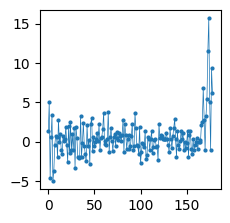

In [226]:
# 1. 학습 데이터 차분 (stationarity 확보)
target_train_diff = target_df_train.diff().dropna()


# [Plot] 학습 데이터 차분 결과
# plt.figure(figsize=(12, 6))
# for col in target_train_diff.columns:
#     plt.plot(target_train_diff.index, target_train_diff[col], label=col)
# plt.title('Differenced Training Data')
# plt.legend()
# plt.show()

for i in [0,1,7]:
    plt.figure(figsize=(2.33,2.33))
    my_col = target_df_train.columns[i]
    print(my_col)
    plt.plot(target_df_train[my_col].values, label=my_col, linewidth=0.5, marker='o',markersize=2)
    # plt.legend()
    # plt.axis('off')
    # plt.tight_layout()
    plt.show()
    plt.figure(figsize=(2.33,2.33))
    plt.plot(target_train_diff[my_col].values, label=my_col, linewidth=0.5, marker='o',markersize=2)
    # plt.axis('off')
    # plt.legend()
    # plt.tight_layout()
    plt.show()

In [227]:
import matplotlib.pyplot as plt

# DFM 모델 피팅 및 내부 변수 추출 (예시 코드)
nfm = DynamicFactor(target_train_diff, k_factors=2, factor_order=1)
nfm_result = nfm.fit(method="powell", maxiter=1000)

# 피팅 결과에서 공유 성분과 로딩 추출
shared_component = nfm_result.factors.smoothed.T
shared_component = np.vstack([shared_component[0], shared_component])

loadings = nfm_result.params.filter(like="loading").values.reshape(target_df_train.shape[1], 2)

# 누적합을 취해 원래 스케일로 복원
shared_component_original = shared_component.cumsum(axis=0)


Optimization terminated successfully.
         Current function value: 18.458637
         Iterations: 17
         Function evaluations: 9882


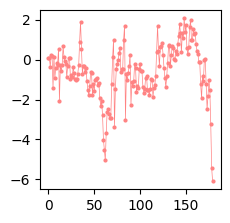

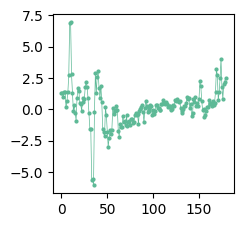

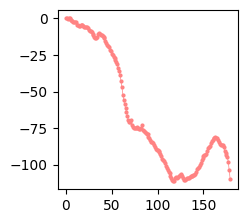

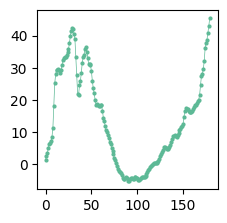

In [146]:
c=["#FF8383", "#5DB996"]
for i in range(2):
    plt.figure(figsize=(2.33,2.33))
    plt.plot(shared_component[:,i],color=c[i],  linewidth=0.5, marker='o',markersize=2)
    plt.show()
for i in range(2):
    plt.figure(figsize=(2.33,2.33))
    plt.plot(shared_component_original[:,i],color=c[i],  linewidth=0.5, marker='o',markersize=2)
    plt.show()

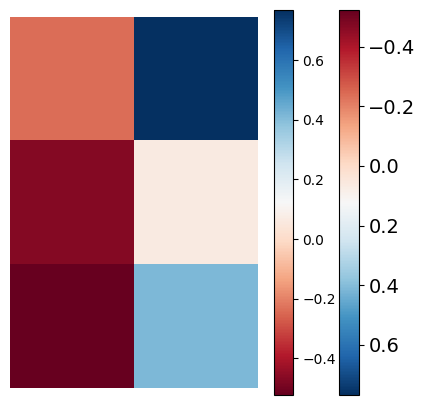

In [135]:
import matplotlib.pyplot as plt
import numpy as np

# 인덱스 0, 1, 7에 해당하는 행만 선택
selected_indices = [0, 1, 7]
selected_loadings = loadings[selected_indices, :]

plt.figure(figsize=(5, 5))
im = plt.imshow(selected_loadings, cmap='RdBu', aspect='equal', interpolation='nearest')
cbar = plt.colorbar(im)
cbar.ax.invert_yaxis()  # 음수 값이 위쪽에 위치하도록 y축 반전
cbar.ax.tick_params(labelsize=14)  # 글자 크기 키우기
plt.colorbar(im)

# plt.title('Selected Loadings Matrix Heatmap (Indices 0, 1, 7)')
# plt.xlabel('Factors')
# plt.ylabel('Variables')

n_factors = selected_loadings.shape[1]
plt.xticks(np.arange(n_factors), [f'Factor {j+1}' for j in range(n_factors)])
# plt.yticks(np.arange(len(selected_indices)), [target_df_train.columns[i] for i in selected_indices])
plt.axis("off")
# plt.tight_layout()
plt.show()


In [ ]:
selected_loadings
-0.24 -0.47 -0.52
0.77 0.07 0.41

array([[-0.24076886,  0.76899029],
       [-0.46847092,  0.06639384],
       [-0.52354561,  0.41232161]])

Seoul_HPI


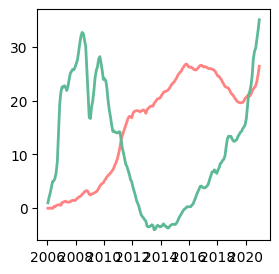

Busan_HPI


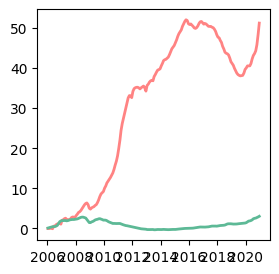

Sejong_HPI


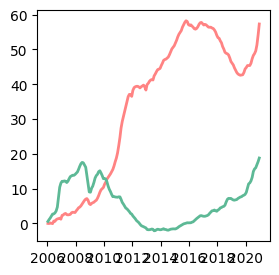

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 예시: shared_component_original, loadings, target_df_train이 이미 계산되어 있다고 가정합니다.
for i in [0,1,7]:
    my_col = target_df_train.columns[i]
    print(my_col)
    # 해당 칼럼에 대한 로딩 벡터 (예: [loading_factor1, loading_factor2])
    current_loadings = loadings[i, :]
    
    # 각 요인의 개별 기여도 계산: 각 요인의 시계열에 해당 로딩을 곱함
    contributions = []
    for j in range(len(current_loadings)):
        contrib = shared_component_original[:, j] * current_loadings[j]
        contributions.append(contrib)
    
    # 두 요인의 개별 기여도의 합을 재구성된 시계열로 계산
    reconstructed_series = np.sum(contributions, axis=0)
    
    # x축 인덱스 결정 (원본 인덱스와 길이가 맞지 않을 경우 range 사용)
    if len(target_df_train.index) == len(reconstructed_series):
        index_for_plot = target_df_train.index
    else:
        index_for_plot = np.arange(len(reconstructed_series))
    

    # 하나의 plot에 factor1과 factor2 기여도, 합산 결과, 그리고 원본 시계열을 함께 그립니다.
    # plt.figure(figsize=(3,3))
    # plt.plot(index_for_plot, contributions[0], label=f'Factor 1 (loading={current_loadings[0]:.2f})', 
    #          color="#FF8383", linewidth=2)
    # plt.plot(index_for_plot, contributions[1], label=f'Factor 2 (loading={current_loadings[1]:.2f})', 
    #          color="#5DB996", linewidth=2)
    # plt.plot(index_for_plot, reconstructed_series, label='Summed Contribution', linewidth=2)
    # plt.plot(target_df_train.index, target_df_train[my_col], linestyle=':', label='Original')
    
    # plt.title(f'Individual Factor Contributions for {my_col}')
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.tight_layout()
    # plt.axis("off")
    plt.show()


Seoul_HPI


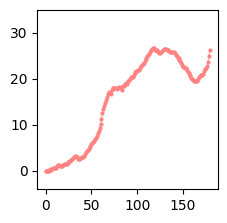

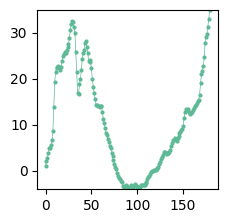

Busan_HPI


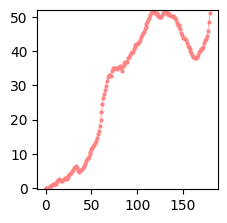

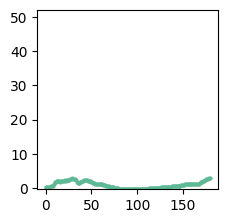

Sejong_HPI


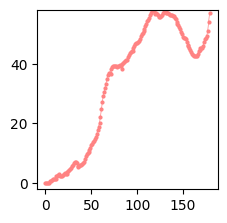

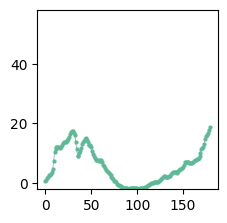

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# 예시: shared_component_original, loadings, target_df_train이 이미 계산되어 있다고 가정합니다.
for i in [0,1,7]:
    my_col = target_df_train.columns[i]
    print(my_col)
    # 해당 칼럼에 대한 로딩 벡터 (예: [loading_factor1, loading_factor2])
    current_loadings = loadings[i, :]
    
    # 각 요인의 개별 기여도 계산: 각 요인의 시계열에 해당 로딩을 곱함
    contributions = []
    for j in range(len(current_loadings)):
        contrib = shared_component_original[:, j] * current_loadings[j]
        contributions.append(contrib)
    
    # 두 요인의 개별 기여도의 합을 재구성된 시계열로 계산
    reconstructed_series = np.sum(contributions, axis=0)
    
    # x축 인덱스 결정 (원본 인덱스와 길이가 맞지 않을 경우 range 사용)
    if len(target_df_train.index) == len(reconstructed_series):
        index_for_plot = target_df_train.index
    else:
        index_for_plot = np.arange(len(reconstructed_series))
    

    # 두 요인의 기여도 contributions[0]과 contributions[1]에 대해 동일한 y 축 범위를 계산합니다.
    common_ymin = min(np.min(contributions[0]), np.min(contributions[1]))
    common_ymax = max(np.max(contributions[0]), np.max(contributions[1]))

    # Factor 1의 기여도 플롯 (별도의 figure)
    plt.figure(figsize=(2.33,2.33))
    plt.plot(contributions[0], 
            label=f'Factor 1 (loading={current_loadings[0]:.2f})', 
            color="#FF8383",  linewidth=0.5, marker='o',markersize=2)
    plt.ylim(common_ymin, common_ymax)  # 공통 y축 범위 설정
    # plt.title('Factor 1 Contribution')
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.axis("off")
    plt.show()

    # Factor 2의 기여도 플롯 (별도의 figure)
    plt.figure(figsize=(2.33,2.33))
    plt.plot(contributions[1], 
            label=f'Factor 2 (loading={current_loadings[1]:.2f})', 
            color="#5DB996",  linewidth=0.5, marker='o',markersize=2)
    plt.ylim(common_ymin, common_ymax)  # 공통 y축 범위 설정
    # plt.title('Factor 2 Contribution')
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    
    # 하나의 plot에 factor1과 factor2 기여도, 합산 결과, 그리고 원본 시계열을 함께 그립니다.
    # plt.figure(figsize=(3,3))
    # plt.plot(index_for_plot, contributions[0], label=f'Factor 1 (loading={current_loadings[0]:.2f})', 
    #          color="#FF8383", linewidth=2)
    # plt.plot(index_for_plot, contributions[1], label=f'Factor 2 (loading={current_loadings[1]:.2f})', 
    #          color="#5DB996", linewidth=2)
    # plt.plot(index_for_plot, reconstructed_series, label='Summed Contribution', linewidth=2)
    # plt.plot(target_df_train.index, target_df_train[my_col], linestyle=':', label='Original')
    
    # plt.title(f'Individual Factor Contributions for {my_col}')
    # plt.xlabel('Time')
    # plt.ylabel('Value')
    # plt.legend()
    # plt.tight_layout()
    # plt.axis("off")
    plt.show()


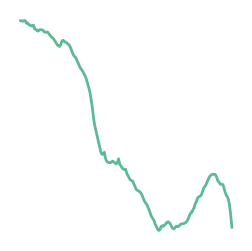

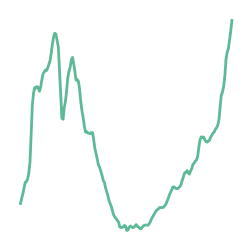

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# shared_component_original: (time_steps, factors) 배열
# target_df_train.index가 shared_component_original의 행 개수와 동일한지 확인합니다.
if len(target_df_train.index) == shared_component_original.shape[0]:
    time_index = target_df_train.index
else:
    time_index = np.arange(shared_component_original.shape[0])

# plt.figure(figsize=(10, 6))
for j in range(shared_component_original.shape[1]):
    plt.figure(figsize=(3,3))
    plt.plot(time_index, shared_component_original[:, j], label=f'Factor {j+1}',color="#5DB996", linewidth=2)
    plt.axis("off")
    plt.show()
# plt.title('Cumulative Shared Components')
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()


In [228]:

# 차분 데이터의 인덱스와 길이가 다를 수 있으므로, 맞지 않으면 range를 사용
index_for_shared = target_train_diff.index
if len(index_for_shared) != shared_component_original.shape[0]:
    index_for_shared = np.arange(shared_component_original.shape[0])
# 4. 원래 스케일 복원: 공유 성분에 로딩을 곱함
shared_component_final = shared_component_original @ loadings.T
shared_component_final_pl = shared_component_original @ loadings.T

# 학습 데이터 분포에 맞게 스케일링
scale_factor = (target_df_train.std() / shared_component_final.std()).values.reshape(1, -1)
shared_component_final = shared_component_final * scale_factor #+ target_df_train.mean().values

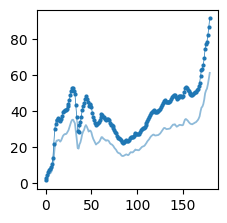

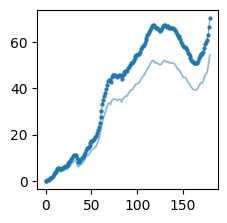

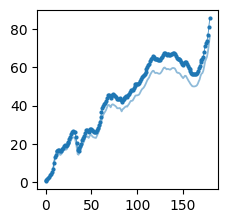

In [ ]:
for i in [0,1,7]:
    col = target_df_train.columns[i]
    plt.figure(figsize=(2.33,2.33))
    # plt.plot(target_df_train.index, target_df_train[col], label=f'Actual {col}')

    plt.plot(shared_component_final_pl[:, i],label=f'Fitted {col}', color="#1f77b4", alpha=0.5, linewidth=1.3)
    plt.plot(shared_component_final[:, i],label=f'Fitted {col}', color="#1f77b4",linewidth=0.5, marker='o',markersize=2)
    # plt.axis("off")
    plt.show()


In [229]:
shared_component_final +=  target_df_train.mean().values
# 기준 날짜(reference_date)에 따른 오프셋 계산 후 적용
reference_index = target_df_train.index.get_loc(REFERENCE_DATE)
offset = target_df_train.iloc[reference_index].values - shared_component_final[reference_index]
shared_component_final = shared_component_final + offset
idiosyncratic_component_final = target_df_train - shared_component_final

In [189]:
REFERENCE_DATE

'2017-11-15'

In [191]:
target_df_train.iloc[142]

Date
Seoul_HPI        100.0
Busan_HPI        100.0
Daegu_HPI        100.0
Incheon_HPI      100.0
Gwangju_HPI      100.0
Daejeon_HPI      100.0
Ulsan_HPI        100.0
Sejong_HPI       100.0
Gyeonggi_HPI     100.0
Gangwon_HPI      100.0
Chungbuk_HPI     100.0
Chungnam_HPI     100.0
Jeonbuk_HPI      100.0
Jeonnam_HPI      100.0
Gyeongbuk_HPI    100.0
Gyeongnam_HPI    100.0
Jeju_HPI         100.0
Name: 2017-11-15 00:00:00, dtype: float64

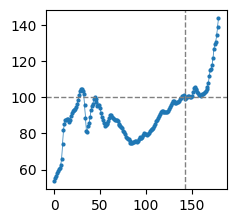

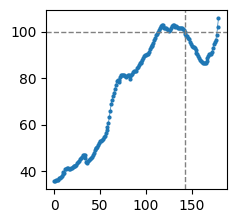

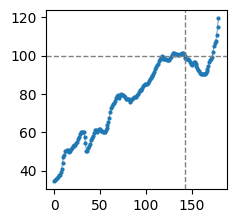

In [199]:
for i in [0,1,7]:
    col = target_df_train.columns[i]
    plt.figure(figsize=(2.33,2.33))
    # plt.plot(target_df_train.index, target_df_train[col], label=f'Actual {col}')

    # plt.plot(shared_component_final_pl[:, i],label=f'Fitted {col}', color="#1f77b4", alpha=0.5, linewidth=1.3)
    plt.plot(shared_component_final[:, i],label=f'Fitted {col}', color="#1f77b4",linewidth=0.5, marker='o',markersize=2)
    # plt.axis("off")
    plt.axvline(x=142, color='gray', linestyle='--', linewidth=1)  # x=3 위치에 빨간 점선
    plt.axhline(y=100, color='gray', linestyle='--', linewidth=1)  # x=3 위치에 빨간 점선
    plt.show()


<Axes: >

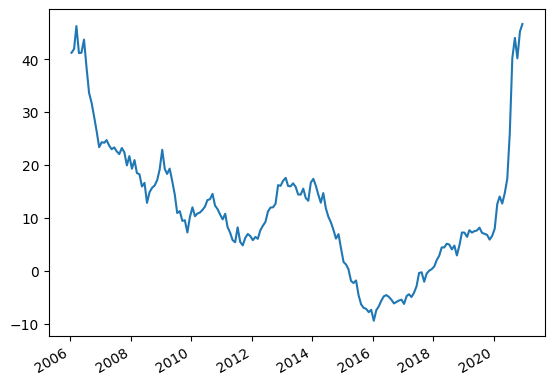

In [213]:
idiosyncratic_component_final[col].plot()

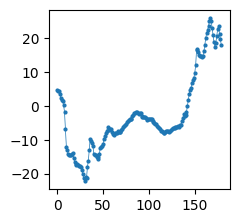

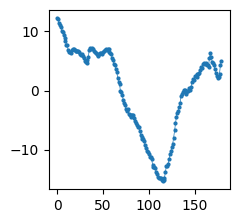

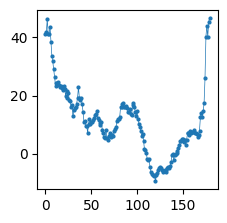

In [172]:
for i in [0,1,7]:
    col = target_df_train.columns[i]
    plt.figure(figsize=(2.33,2.33))
    plt.plot(idiosyncratic_component_final[col].values,label=f'Fitted {col}', linewidth=0.5, marker='o',markersize=2)
    # plt.axis("off")
    plt.show()


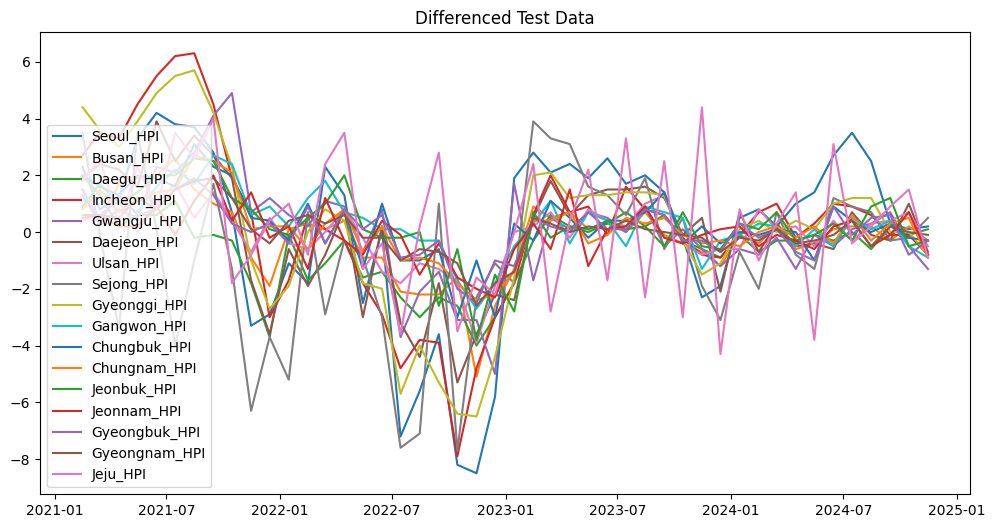

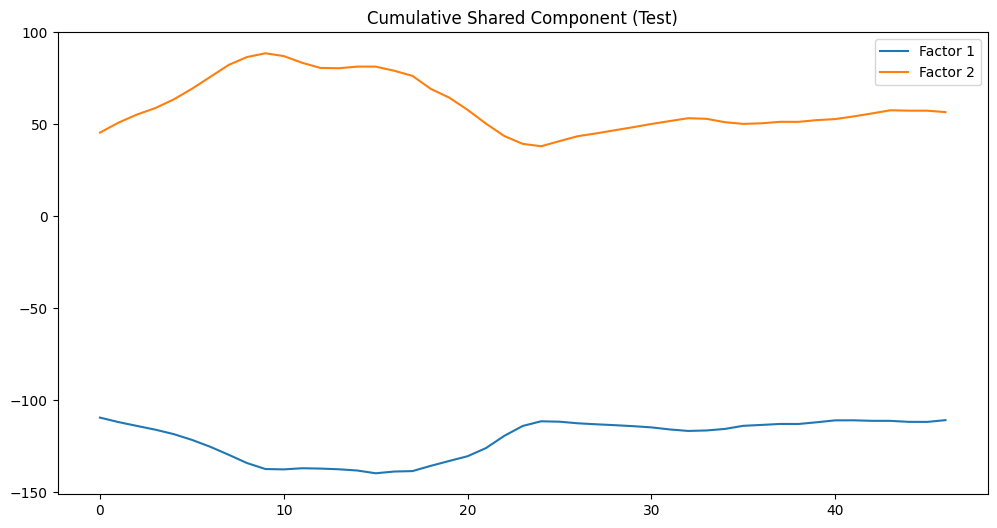

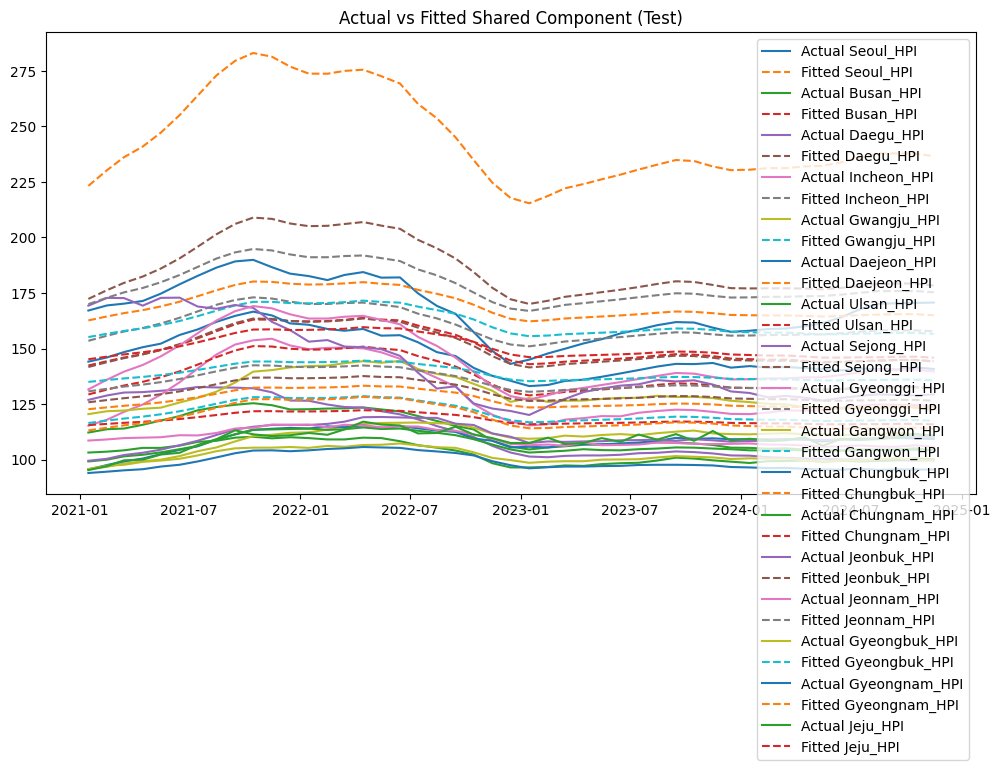

In [ ]:



# # 5. 테스트 데이터 처리
target_test_diff = target_df_test.diff().dropna()

# [Plot] 테스트 데이터 차분 결과
plt.figure(figsize=(12, 6))
for col in target_test_diff.columns:
    plt.plot(target_test_diff.index, target_test_diff[col], label=col)
plt.title('Differenced Test Data')
plt.legend()
plt.show()

nfm_test_result = nfm_result.apply(target_test_diff)
shared_component_test = nfm_test_result.factors.smoothed.T
# 학습 데이터 마지막 값과 결합하여 연속성을 부여
shared_component_test = np.vstack([shared_component_original[-1, :], shared_component_test])
shared_component_test_original = shared_component_test.cumsum(axis=0)

# [Plot] 테스트 데이터의 누적 공유 성분
plt.figure(figsize=(12, 6))
index_for_shared_test = target_test_diff.index
if len(index_for_shared_test) != shared_component_test_original.shape[0]:
    index_for_shared_test = np.arange(shared_component_test_original.shape[0])
for i in range(shared_component_test_original.shape[1]):
    plt.plot(index_for_shared_test, shared_component_test_original[:, i], label=f'Factor {i+1}')
plt.title('Cumulative Shared Component (Test)')
plt.legend()
plt.show()

shared_component_test_final = shared_component_test_original @ loadings.T
shared_component_test_final = shared_component_test_final * scale_factor + target_df_test.mean().values + offset
idiosyncratic_component_test_final = target_df_test - shared_component_test_final

<Axes: >

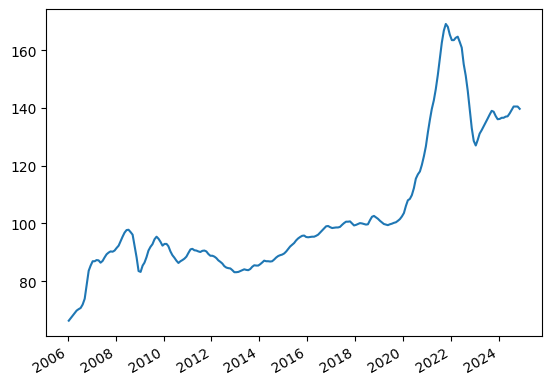

In [231]:
target_df["Gyeonggi_HPI"].plot()

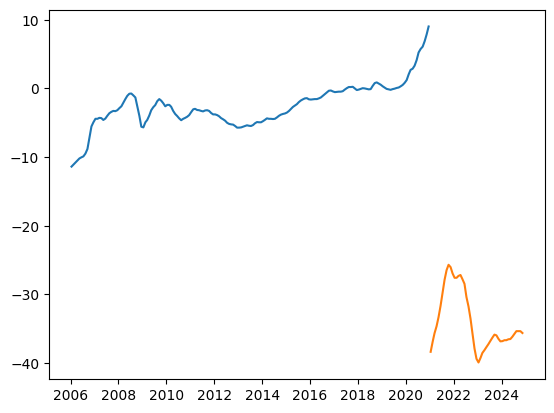

In [233]:
plt.plot(idiosyncratic_component_final["Gyeonggi_HPI"])
plt.plot(idiosyncratic_component_test_final["Gyeonggi_HPI"])

In [215]:
idiosyncratic_component_test_final

Date,Seoul_HPI,Busan_HPI,Daegu_HPI,Incheon_HPI,Gwangju_HPI,Daejeon_HPI,Ulsan_HPI,Sejong_HPI,Gyeonggi_HPI,Gangwon_HPI,Chungbuk_HPI,Chungnam_HPI,Jeonbuk_HPI,Jeonnam_HPI,Gyeongbuk_HPI,Gyeongnam_HPI,Jeju_HPI
2021-01-15,-4.028114,5.390851,28.731405,44.837635,16.738551,40.345209,21.017797,30.856601,38.725264,31.202493,35.045241,61.016912,34.976857,48.511165,42.989781,29.006680,0.409166
2021-02-15,-8.820634,4.954439,28.565209,45.231062,16.544091,40.459812,19.217305,30.411605,40.212781,31.452468,36.221795,61.266765,34.883988,47.833993,43.400537,28.382201,1.044586
2021-03-15,-13.815887,3.620058,28.052741,46.844951,15.583877,41.371496,17.980725,27.048112,41.429737,32.133775,37.116172,62.298037,35.740230,47.450386,42.881108,27.937451,2.650535
2021-04-15,-17.417697,3.782885,26.601926,48.577165,15.202519,42.234890,17.423658,20.803513,42.443728,32.553581,37.716469,62.542277,35.927125,46.759092,43.316097,27.416601,1.977852
2021-05-15,-20.380911,3.816066,25.161264,51.036008,14.265223,42.169605,15.364474,20.699325,43.761954,32.430345,38.890700,63.098701,36.352646,45.854164,42.865763,27.402274,3.121698
2021-06-15,-24.039740,3.405436,23.145147,53.972982,14.710614,43.941510,13.730235,16.224529,45.418170,32.965799,39.711664,63.791519,37.087406,45.339295,42.309368,26.620716,2.415433
2021-07-15,-29.039538,3.167074,21.202482,57.299274,14.629660,43.979983,12.377713,6.995125,47.277269,33.909396,40.015972,64.448436,37.584016,43.597012,42.212113,26.231808,4.115512
2021-08-15,-34.419519,1.477835,17.650725,60.626951,14.983953,44.692828,9.535328,0.399108,49.204102,34.192391,41.615231,66.182571,38.470463,42.893803,42.317074,25.861789,4.646084
2021-09-15,-38.189686,-0.628671,14.474703,62.954390,16.715371,44.996893,7.926014,-2.563722,50.623775,35.497257,42.327052,67.689494,39.232893,43.255900,41.867663,25.514016,6.497987
2021-10-15,-41.017165,-2.069260,12.138113,63.675041,19.989273,45.343315,6.360703,-6.730297,51.401384,36.929372,43.177138,69.082221,39.205492,42.579384,40.961790,25.106222,3.159621
